## Formulação matemática do problema da Grade Horária na UFPR Campus Pontal (Timetabling)


### Objetivo

O objetivo desta modelagem é minimizar a quantidade de vezes que os professores da UFPR Campus Pontal vão ao campus.
Vamos levar em conta dados originais obtidos em contato com a universidade e restrições reais.


### Parâmetros

Para modelar, temos as variáveis: 

* **T**: conjunto de turmas (8 turmas em LCE)
* **P**: conjunto de professores (16 professores em LCE)
* **H**: conjunto de horários das aulas (1 ou 2 - primeiro ou segundo horário)
* **D**: conjunto de dias da semana que ocorrem aulas (varia de segunda a sexta)

Total de combinações: $8 * 16 * 2 * 5 = 1280$.


### Variáveis de Decisão

As variáveis $x_{p,t,d,h}$ são inteiras e binárias, que definem se o professor $p$ irá (1) ou não (0) ministrar aula para a turma $t \in T$ no dia $d \in D$ e no horário $h \in H$.


### Problema de Otimização

$$
\begin{align}
    \text{minimizar \ \ \ \ \ } & \sum_{d=1}^{5}x_{p,t,d,h} \\
    \text{sujeito a \ \ \ \ \ } & \sum_{p=1}^{16}x_{p,t,d,h} \leq 1 \\
                                & \sum_{t=1}^{8}x_{p,t,d,h} \leq 1 \\
                                & \sum_{p=1}^{16}\sum_{h=1}^{2}x_{p,t,d,h} = HT_{t,d} \\
                                & \sum_{d=1}^{5}\sum_{h=1}^{2}x_{p,t,d,h} = R_{p,t} \\
                                & \sum_{t \in T_1}\sum_{p \in P_1}x_{p,t,d,h} = 2 \\
                                & \sum_{h=1}^{}x_{ptdh} \leq 6
\end{align}
$$

onde:

- $H$:
- $T_{t,d}$:
- $R_{p,t}$:
- $T_1$: subconjunto das turmas $T$ com aulas comuns às três habilitações
- $P_1$: subconjunto dos professores $P$ que ministram aulas nas disciplinas comuns

### Explicação das Restrições

1. Cada combinação de turma, horário e dia da semana terá somente 1 professor alocado
2. Cada combinação de professor, horário e dia da semana terá somente 1 turma sendo ministrada
3. 
4.
5.

## v4
Nessa versão, o objetivo é acrescentar a restrição de não haver intervalos entre aulas de um mesmo professor, de uma mesma disciplina, para uma mesma turma no mesmo dia.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import gurobipy as gp
from gurobipy import GRB

def constroi_lista(df:pd.DataFrame, coluna:str):
    lista = list(df[df['Curso'].isin(['LCE','LCEFISICA', 'LCEMATEMATICA', 'LCEQUIMICA','EAQ','ECV','EAS','OCEANO'])][coluna].dropna().unique()) #'LCE','LCEFISICA', 'LCEMATEMATICA', 'LCEQUIMICA','EAQ','ECV','EAS','OCEANO'
    return lista


def get_hora_aula_materia(professor,materia, turma, df):
    resultado = df.query("Semestre_Curso == @turma and Materia == @materia and Professor == @professor")
    if not resultado.empty:
        return float(resultado['Total_Horas'].iloc[0])
    else:
        return 0


def get_turno(turma, df):
    resultado = df.query("Semestre_Curso == @turma")
    if not resultado.empty:
        return resultado['Tipo_Curso'].iloc[0]
    else:
        return 0
    

def get_campus(turma,disciplina, df):
    resultado = df.query("Semestre_Curso == @turma and Materia == @disciplina")
    return not resultado.empty


In [2]:
grade_compilada = pd.read_csv('dados/grade_compilada.csv', sep=';')
grade_compilada_tratado = pd.read_csv('dados/grade_compilada_tratado.csv', sep=',')
hora_aula_materia = pd.read_csv('dados/hora_aula_materia.csv', sep=',')
materias_comuns = pd.read_csv('dados/materias_comuns.csv', sep=',')
professores_materias = pd.read_csv('dados/professores_materias.csv', sep=',')

In [3]:
hora_aula_materia.tail()

,Professor,Materia,Semestre_Curso,Curso,Total_Horas,Periodos_Total
188,VALDIR,PRATICAPEDAGOGICADOENSINOCEM335,5_LCEMATEMATICA,LCEMATEMATICA,2,1.0
189,VALDIR,PRATICAPEDAGOGICADOENSINOCEM335,5_LCEQUIMICA,LCEQUIMICA,2,1.0
190,VALDIR,PRATICAPEDAGOGICAMATEMATICAIICEM339,7_LCEMATEMATICA,LCEMATEMATICA,4,2.0
191,VIRNEI,FISICAGERAL,3_EAQ,EAQ,4,2.0
192,VIRNEI,FISICAII,3_EAS,EAS,3,2.0


In [4]:
professores_materias[professores_materias['Curso'].isin(['LCE'])].count()

Professor     14
Campus        14
Curso         14
Tipo_Curso    14
Materia       14
dtype: int64

## Modelagem


In [5]:
# altera o index do hora_aula_materia
df_hor = hora_aula_materia.set_index(['Professor','Semestre_Curso','Materia'])
df_hor

Curso  \
Professor Semestre_Curso  Materia                                              
ALEX      1_EAS           CALCULODIFERENCIALEINTEGRALI                   EAS   
          1_ECV           CALCULOI                                       ECV   
          5_LCEMATEMATICA GEOMETRIAECONSTRUCOESCEM319          LCEMATEMATICA   
ARMANI    1_EAS           INTRODUCAOAENGENHARIAAMBIENTAL                 EAS   
          7_EAS           POLUICAODOAR                                   EAS   
...                                                                      ...   
VALDIR    5_LCEMATEMATICA PRATICAPEDAGOGICADOENSINOCEM335      LCEMATEMATICA   
          5_LCEQUIMICA    PRATICAPEDAGOGICADOENSINOCEM335         LCEQUIMICA   
          7_LCEMATEMATICA PRATICAPEDAGOGICAMATEMATICAIICEM339  LCEMATEMATICA   
VIRNEI    3_EAQ           FISICAGERAL                                    EAQ   
          3_EAS           FISICAII                                       EAS   

                                                               Total_Horas  \
Professor Semestre_Curso  Materia                                            
ALEX      1_EAS           CALCULODIFERENCIALEINTEGRALI                   4   
          1_ECV           CALCULOI                                       4   
          5_LCEMATEMATICA GEOMETRIAECONSTRUCOESCEM319                    4   
ARMANI    1_EAS           INTRODUCAOAENGENHARIAAMBIENTAL                 4   
          7_EAS           POLUICAODOAR                                   3   
...                                                                    ...   
VALDIR    5_LCEMATEMATICA PRATICAPEDAGOGICADOENSINOCEM335                2   
          5_LCEQUIMICA    PRATICAPEDAGOGICADOENSINOCEM335                2   
          7_LCEMATEMATICA PRATICAPEDAGOGICAMATEMATICAIICEM339            4   
VIRNEI    3_EAQ           FISICAGERAL                                    4   
          3_EAS           FISICAII                                       3   

                                                               Periodos_Total  
Professor Semestre_Curso  Materia                                              
ALEX      1_EAS           CALCULODIFERENCIALEINTEGRALI                    2.0  
          1_ECV           CALCULOI                                        2.0  
          5_LCEMATEMATICA GEOMETRIAECONSTRUCOESCEM319                     2.0  
ARMANI    1_EAS           INTRODUCAOAENGENHARIAAMBIENTAL                  2.0  
          7_EAS           POLUICAODOAR                                    2.0  
...                                                                       ...  
VALDIR    5_LCEMATEMATICA PRATICAPEDAGOGICADOENSINOCEM335                 1.0  
          5_LCEQUIMICA    PRATICAPEDAGOGICADOENSINOCEM335                 1.0  
          7_LCEMATEMATICA PRATICAPEDAGOGICAMATEMATICAIICEM339             2.0  
VIRNEI    3_EAQ           FISICAGERAL                                     2.0  
          3_EAS           FISICAII                                        2.0  

[193 rows x 3 columns]

In [6]:
hora_aula_materia.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 193 entries, 0 to 192
Data columns (total 6 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Professor       193 non-null    object 
 1   Materia         193 non-null    object 
 2   Semestre_Curso  193 non-null    object 
 3   Curso           193 non-null    object 
 4   Total_Horas     193 non-null    int64  
 5   Periodos_Total  193 non-null    float64
dtypes: float64(1), int64(1), object(4)
memory usage: 9.2+ KB


In [7]:
get_hora_aula_materia('ALEX','CALCULODIFERENCIALEINTEGRALI', '1_EAS', hora_aula_materia)

4.0

In [8]:
df_turno = grade_compilada_tratado[['Tipo_Curso','Semestre_Curso']].set_index(['Semestre_Curso'])
get_turno("1_EAQ", df_turno)

'MATUTINO'

In [9]:
grade_compilada_tratado.columns

Index(['Campus', 'Curso', 'Periodo_dia', 'Horario', 'Semestre', 'Dia',
       'Periodo_Aula', 'Tipo_Curso', 'Materia', 'Professor', 'Observacao',
       'Semestre_Curso'],
      dtype='object')

In [10]:
grade_compilada_tratado[grade_compilada_tratado['Campus']=='MIRASOL'][['Semestre_Curso','Materia','Campus']].set_index(['Semestre_Curso','Materia'])

Campus
Semestre_Curso Materia                        
1_EAQ          INTRODUCAOAAQUICULTURA  MIRASOL
               INTRODUCAOAAQUICULTURA  MIRASOL
               PROBABILIDADE           MIRASOL
               PROBABILIDADE           MIRASOL
               INTRODUCAOAQUALIDADE    MIRASOL
...                                        ...
7_LCEQUIMICA   FISICOQUIMICACEM365     MIRASOL
               FISICOQUIMICACEM365     MIRASOL
               FISICOQUIMICACEM365     MIRASOL
3_OCEANO       FISICAEXPERIMENTALII    MIRASOL
               FISICAEXPERIMENTALII    MIRASOL

[317 rows x 1 columns]

In [11]:
df_mirassol = grade_compilada_tratado[grade_compilada_tratado['Campus']=='MIRASOL'][['Semestre_Curso','Materia','Campus']].set_index(['Semestre_Curso','Materia'])
get_campus('1_EAQ','INTRODUCAOAAQUICULTURA', df_mirassol)

True

### Parâmetros

In [12]:
grade_compilada_tratado

,Campus,Curso,Periodo_dia,Horario,Semestre,Dia,Periodo_Aula,Tipo_Curso,Materia,Professor,Observacao,Semestre_Curso
0,MIRASOL,EAQ,MANHA,1,1,SEGUNDA,MATUTINO,MATUTINO,INTRODUCAOAAQUICULTURA,LAGREZE,NaN,1_EAQ
1,MIRASOL,EAQ,MANHA,2,1,SEGUNDA,MATUTINO,MATUTINO,INTRODUCAOAAQUICULTURA,LAGREZE,NaN,1_EAQ
2,MIRASOL,EAQ,MANHA,3,1,SEGUNDA,MATUTINO,MATUTINO,PROBABILIDADE,CENDON,NaN,1_EAQ
3,MIRASOL,EAQ,MANHA,4,1,SEGUNDA,MATUTINO,MATUTINO,PROBABILIDADE,CENDON,NaN,1_EAQ
4,MIRASOL,EAQ,MANHA,1,1,TERCA,MATUTINO,MATUTINO,INTRODUCAOAQUALIDADE,SACHSIDA,NaN,1_EAQ
...,...,...,...,...,...,...,...,...,...,...,...,...
549,PONTAL,OCEANO,TARDE,4,9,TERCA,VESPERTINO,INTEGRAL,GASESDISOLVIDOSEACIDIFICACAO,TATIANE,NaN,9_OCEANO
550,PONTAL,OCEANO,TARDE,1,9,QUARTA,VESPERTINO,INTEGRAL,INTRODUCAOAMODELAGEMDEPROCESSOS,DOURADO,NaN,9_OCEANO
551,PONTAL,OCEANO,TARDE,2,9,QUARTA,VESPERTINO,INTEGRAL,INTRODUCAOAMODELAGEMDEPROCESSOS,DOURADO,NaN,9_OCEANO
552,PONTAL,OCEANO,TARDE,1,9,QUINTA,VESPERTINO,INTEGRAL,INTRODUCAOAMODELAGEMDEPROCESSOS,DOURADO,NaN,9_OCEANO


In [13]:
grade_compilada_tratado_menor = grade_compilada_tratado[grade_compilada_tratado['Professor'] == 'LAGREZE']
grade_compilada_tratado_menor

,Campus,Curso,Periodo_dia,Horario,Semestre,Dia,Periodo_Aula,Tipo_Curso,Materia,Professor,Observacao,Semestre_Curso
0,MIRASOL,EAQ,MANHA,1,1,SEGUNDA,MATUTINO,MATUTINO,INTRODUCAOAAQUICULTURA,LAGREZE,NaN,1_EAQ
1,MIRASOL,EAQ,MANHA,2,1,SEGUNDA,MATUTINO,MATUTINO,INTRODUCAOAAQUICULTURA,LAGREZE,NaN,1_EAQ
63,MIRASOL,EAQ,MANHA,2,7,QUARTA,MATUTINO,MATUTINO,MALACOCULTURA,LAGREZE,NaN,7_EAQ
64,MIRASOL,EAQ,MANHA,3,7,QUARTA,MATUTINO,MATUTINO,MALACOCULTURA,LAGREZE,NaN,7_EAQ
74,MIRASOL,EAQ,MANHA,3,9,SEGUNDA,MATUTINO,MATUTINO,ELABORACAODEPROJETOS,LAGREZE,NaN,9_EAQ
75,MIRASOL,EAQ,MANHA,4,9,SEGUNDA,MATUTINO,MATUTINO,ELABORACAODEPROJETOS,LAGREZE,NaN,9_EAQ
84,MIRASOL,EAQ,MANHA,1,9,QUINTA,MATUTINO,MATUTINO,HIDRAULICAAQUICULTURA,LAGREZE,NaN,9_EAQ
85,MIRASOL,EAQ,MANHA,2,9,QUINTA,MATUTINO,MATUTINO,HIDRAULICAAQUICULTURA,LAGREZE,NaN,9_EAQ
86,MIRASOL,EAQ,MANHA,3,9,QUINTA,MATUTINO,MATUTINO,HIDRAULICAAQUICULTURA,LAGREZE,NaN,9_EAQ
87,MIRASOL,EAQ,MANHA,4,9,QUINTA,MATUTINO,MATUTINO,HIDRAULICAAQUICULTURA,LAGREZE,NaN,9_EAQ


In [14]:

# Define os conjuntos
professores = constroi_lista(df = grade_compilada_tratado, coluna = 'Professor') 
turmas = constroi_lista(df = grade_compilada_tratado, coluna = 'Semestre_Curso')
campus = constroi_lista(df = grade_compilada_tratado, coluna = 'Campus')
# turno = constroi_lista(df = grade_compilada_tratado, coluna='Tipo_Curso') #Matutino/Noturno
dias_semana = constroi_lista(df = grade_compilada_tratado, coluna = 'Dia') # range(1, 6)
horarios = range(1, 14) 
disciplinas = constroi_lista(df = grade_compilada_tratado, coluna = 'Materia') 

professores_comuns = materias_comuns['Professor'].unique().tolist()
turmas_comuns = materias_comuns['Semestre_Curso'].unique().tolist()
disciplinas_comuns = materias_comuns['Materia'].unique().tolist()

"""
# Define os conjuntos
professores = constroi_lista(df = grade_compilada_tratado_menor, coluna = 'Professor') 
turmas = constroi_lista(df = grade_compilada_tratado_menor, coluna = 'Semestre_Curso')
campus = constroi_lista(df = grade_compilada_tratado_menor, coluna = 'Campus')
# turno = constroi_lista(df = grade_compilada_tratado, coluna='Tipo_Curso') #Matutino/Noturno
dias_semana = constroi_lista(df = grade_compilada_tratado_menor, coluna = 'Dia') # range(1, 6)
horarios = range(1, 14) 
disciplinas = constroi_lista(df = grade_compilada_tratado_menor, coluna = 'Materia') 

professores_comuns = []#materias_comuns['Professor'].unique().tolist()
turmas_comuns = []#materias_comuns['Semestre_Curso'].unique().tolist()
disciplinas_comuns = []#materias_comuns['Materia'].unique().tolist()
"""


"\n# Define os conjuntos\nprofessores = constroi_lista(df = grade_compilada_tratado_menor, coluna = 'Professor') \nturmas = constroi_lista(df = grade_compilada_tratado_menor, coluna = 'Semestre_Curso')\ncampus = constroi_lista(df = grade_compilada_tratado_menor, coluna = 'Campus')\n# turno = constroi_lista(df = grade_compilada_tratado, coluna='Tipo_Curso') #Matutino/Noturno\ndias_semana = constroi_lista(df = grade_compilada_tratado_menor, coluna = 'Dia') # range(1, 6)\nhorarios = range(1, 14) \ndisciplinas = constroi_lista(df = grade_compilada_tratado_menor, coluna = 'Materia') \n\nprofessores_comuns = []#materias_comuns['Professor'].unique().tolist()\nturmas_comuns = []#materias_comuns['Semestre_Curso'].unique().tolist()\ndisciplinas_comuns = []#materias_comuns['Materia'].unique().tolist()\n"

In [15]:
# Define os turnos
turno_horarios = {
    'MATUTINO': [1,2,3,4],  # Horários no turno matutino
    'VESPERTINO':[5,6,7,8,9],
    'NOTURNO': [10,11,12,13],  # Horários no turno noturno
    'INTEGRAL': [1,2,3,4,5,6,7,8,9]  # Horários permitidos para cursos integrais
}


# Atualiza o mapeamento de turmas para seus turnos usando a função `get_turno`
mapa_turma_turno = {}
for turma in turmas:
    turno = get_turno(turma, df_turno)  # Determina o turno da turma
    if turno in turno_horarios:
        mapa_turma_turno[turma] = turno_horarios[turno]
    else:
        raise ValueError(f"Turno desconhecido para a turma: {turma}")

In [16]:
mapa_turma_turno

{'1_EAQ': [1, 2, 3, 4],
 '3_EAQ': [1, 2, 3, 4],
 '5_EAQ': [1, 2, 3, 4],
 '7_EAQ': [1, 2, 3, 4],
 '9_EAQ': [1, 2, 3, 4],
 '1_EAS': [5, 6, 7, 8, 9],
 '3_EAS': [5, 6, 7, 8, 9],
 '5_EAS': [5, 6, 7, 8, 9],
 '9_EAS': [5, 6, 7, 8, 9],
 '7_EAS': [5, 6, 7, 8, 9],
 '1_ECV': [5, 6, 7, 8, 9],
 '3_ECV': [5, 6, 7, 8, 9],
 '5_ECV': [5, 6, 7, 8, 9],
 '7_ECV': [5, 6, 7, 8, 9],
 '9_ECV': [5, 6, 7, 8, 9],
 '1_LCE': [10, 11, 12, 13],
 '3_LCE': [10, 11, 12, 13],
 '5_LCEFISICA': [10, 11, 12, 13],
 '5_LCEMATEMATICA': [10, 11, 12, 13],
 '5_LCEQUIMICA': [10, 11, 12, 13],
 '7_LCEFISICA': [10, 11, 12, 13],
 '7_LCEMATEMATICA': [10, 11, 12, 13],
 '7_LCEQUIMICA': [10, 11, 12, 13],
 '1_OCEANO': [1, 2, 3, 4, 5, 6, 7, 8, 9],
 '3_OCEANO': [1, 2, 3, 4, 5, 6, 7, 8, 9],
 '5_OCEANO': [1, 2, 3, 4, 5, 6, 7, 8, 9],
 '7_OCEANO': [1, 2, 3, 4, 5, 6, 7, 8, 9],
 '9_OCEANO': [1, 2, 3, 4, 5, 6, 7, 8, 9]}

In [19]:
# Inicialização do modelo
model = gp.Model("Alocação_Professores")

# Cria as variáveis de decisão
x = model.addVars(professores, disciplinas, turmas, dias_semana, horarios, vtype=GRB.BINARY, name="x")
# Essa variável serve como indicador binário para saber se a disciplina mm está sendo ministrada pelo professor pp no dia dd e horário hh.
y = model.addVars(professores,disciplinas,dias_semana,horarios,vtype=GRB.BINARY, name="y")
# Essas são as variáveis cuja soma será minimizada: a quantidade de idas dos professores à universidade
idas = model.addVars(professores, dias_semana, vtype=gp.GRB.INTEGER, name="idas")

#inicio_fim_bloco = model.addVars(professores, disciplinas, turmas, dias_semana, horarios, vtype=GRB.BINARY, name="inicio_fim_bloco")
#qtd_blocos = model.addVars(professores, disciplinas, turmas, dias_semana, vtype=GRB.INTEGER, name="qtd_blocos")

# Variáveis de folga
#r2 = model.addVars(professores,dias_semana,horarios, vtype=GRB.BINARY, name="r2") # colocar na FO
#r3 = model.addVars(turmas,dias_semana,horarios,vtype=GRB.BINARY, name="r3") # colocar na FO
#r5 = model.addVars(tipo_curso,turmas,dias_semana,horarios,vtype=GRB.BINARY, name="r5") # colocar na FO
#r6 = model.addVars(professores,disciplinas,dias_semana,horarios,vtype=GRB.BINARY, name="r6") # colocar na FO
#r7 = model.addVars(horarios,dias_semana, vtype=GRB.BINARY, name="r7") # colocar na FO
#r8 = model.addVars(turmas,disciplinas,dias_semana, vtype=GRB.BINARY, name="r8") # colocar na FO

MemoryError: 

In [23]:
# Define a função objetivo
model.setObjective(
    """
    100*gp.quicksum(r2[p,d,h]                               
                for p in professores
                for d in dias_semana
                for h in horarios) +
    100*gp.quicksum(r3[t,d,h]                                                           
                for t in turmas 
                for d in dias_semana 
                for h in horarios) +
    100*gp.quicksum(r6[p,m,d,h]
                for m in disciplinas 
                for p in professores
                for d in dias_semana 
                for h in horarios) +
    100*gp.quicksum(r7[h,d]                                                           
                for d in dias_semana 
                for h in horarios) +
    100*gp.quicksum(r8[t,m,d]
                for m in disciplinas 
                for t in turmas 
                for d in dias_semana) +
    """
    gp.quicksum(idas[p,d]
                for p in professores
                for d in dias_semana)# +
    #0.1*gp.quicksum(qtd_blocos[p,m,t,d]
    #            for p in professores
    #            for m in disciplinas
    #            for t in turmas
    #            for d in dias_semana)
    ,GRB.MINIMIZE)
                    

# Restrição 2 - Cada professor tem no máximo uma aula em um horário específico
for p in professores:
    for d in dias_semana:
        for h in horarios:
            model.addConstr(gp.quicksum(x[p,m,t,d,h]                                         
                                        for m in disciplinas 
                                        for t in turmas 
                                        if m not in disciplinas_comuns) <= 1, name=f'R2_{p}_{d}_{h}') # + 999*r2[p,d,h] - precisei adicionar o if para não dar conflito com 6

# Restrição 3 - Cada turma tem no máximo um professor em um horário específico
for t in turmas:
    for d in dias_semana:
        for h in horarios:
            model.addConstr(gp.quicksum(x[p,m,t,d,h] 
                                        for p in professores 
                                        for m in disciplinas 
                                        if m not in disciplinas_comuns) <= 1, name=f'R3_{t}_{d}_{h}') # + 999*r3[t,d,h] - precisei adicionar o if para não dar conflito com 6

# Restrição 5 
# "associa cada disciplina ao professora que ira lecionar cada uma delas e quantos periodos deve aparecer"
for p in professores:
    for t in turmas:
        for m in disciplinas:
            model.addConstr(gp.quicksum(x[p,m,t,d,h] for d in dias_semana for h in horarios) == get_hora_aula_materia(p,m,t), name=f'R5_{p}_{m}_{t}') # R_p,t

# Restrição 6 # Conflito com essa tbm
# # T1 ⊂ T (subconj. das turmas com aulas comuns) e P1 ⊂ P (subconj. dos professores das aulas comuns)
# for p in professores_comuns:
#     for m in disciplinas_comuns:        
#         for d in dias_semana:
#             for h in horarios:
#                 model.addConstr(gp.quicksum(x[p,m,t,d,h] for t in turmas_comuns) <= 3 +999*r6[p,m,d,h] , name=f'R6_{p}_{m}_{d}_{h}') 
for p in professores_comuns:
    for m in disciplinas_comuns:
        for d in dias_semana:
            for h in horarios:
                # Garante que se uma disciplina comum está alocada, ocorre simultaneamente para todas as turmas
                model.addConstr(
                    gp.quicksum(x[p,m,t,d,h] for t in turmas_comuns) ==
                    len(turmas_comuns) * y[p, m, d, h],
                    name=f'R6_{p}_{m}_{d}_{h}'
                )

# Restrição 7
# Garante que as aulas sejam alocadas nas 6 salas de aulas disponíveis do campus mirassol
# Isto é, a quantidade de aulas a cada horário deve ser no máximo 6, pois esse é o limite de salas
# for h in horarios:
#     for d in dias_semana:    
#         model.addConstr(gp.quicksum(x[p,m,t,d,h]
#                                     for p in professores 
#                                     for m in disciplinas
#                                     for t in turmas
#                                    ) <= 6 + 9999*r7[h,d]  , name=f'R7_{d}_{h}')
for h in horarios:
    for d in dias_semana:
        model.addConstr(
            gp.quicksum(
                x[p,m,t,d,h]
                for p in professores
                for m in disciplinas
                for t in turmas
                if get_campus(t, m)  #  + 9999 * r7[h, d] - Verifica se a turma e a disciplina estão em Mirassol
            ) <= 6,
            name=f'R7_{d}_{h}'
        )
        
# Restrição 8
# Serve para garantir que disciplinas sejam alocadas apenas nos horários permitidos do turno da turma 
for t in turmas:
    horarios_permitidos = mapa_turma_turno[t]  # Horários válidos com base no turno
    for m in disciplinas:
        for d in dias_semana:
            model.addConstr(
                gp.quicksum(x[p,m,t,d,h] for p in professores for h in horarios if h not in horarios_permitidos) <= 0, #  + 9999*r8[t,m,d]
#                 gp.quicksum(x[p,m,t,d,h] for p in professores for h in horarios),
                name=f'R8_{t}_{m}_{d}'
            )

# Restrição 9
# Serve para garantir que a variável idas é sempre maior ou igual que a variável x
for p in professores:
    for d in dias_semana:       
        for m in disciplinas:
            for t in turmas:
                for h in horarios:
                    model.addConstr(idas[p,d] >= x[p,m,t,d,h], name=f'R9_{p}_{m}_{t}_{d}_{h}')
                    
# Restrição 10
# Proíbe intervalos entre aulas para cada combinação de professor, disciplina, dia da semana e turma 
for p in professores:
    for m in disciplinas:
        for t in turmas:
            for d in dias_semana:
            
                # Primeiro e último horários
                #model.addConstr(inicio_fim_bloco[p,m,t,d,horarios[0]] == x[p,m,t,d,horarios[0]], name=f'R_10_aux_{p}_{m}_{t}_{d}_{horarios[0]}')
                #model.addConstr(inicio_fim_bloco[p,m,t,d,horarios[-1]] == x[p,m,t,d,horarios[-1]], name=f'R_10_aux_{p}_{m}_{t}_{d}_{horarios[-1]}')

                # Demais horários
                #for h in range(horarios[1],horarios[-1]):
                #    model.addConstr(inicio_fim_bloco[p,m,t,d,h] == (x[p,m,t,d,h] - x[p,m,t,d,h-1])**2, name=f'R_10_aux_{p}_{m}_{t}_{d}_{h}')

                # Calcular a quantidade de blocos por p,m,t,d
                model.addConstr(
                    (x[p,m,t,d,horarios[0]]
                    + gp.quicksum((x[p,m,t,d,h] - x[p,m,t,d,h-1])**2 for h in range(horarios[1],horarios[-1]))
                    + x[p,m,t,d,horarios[-1]]) / 2
                    <= 1
                    ,name=f'R_10_{p}_{m}_{t}_{d}'
                )

model.write('outputs/v4/completo/modelo_v4.lp')

In [24]:
# Resolve o modelo
model.optimize()

Gurobi Optimizer version 11.0.3 build v11.0.3rc0 (win64 - Windows 11.0 (22631.2))

CPU model: 12th Gen Intel(R) Core(TM) i7-12700H, instruction set [SSE2|AVX|AVX2]
Thread count: 14 physical cores, 20 logical processors, using up to 20 threads

Optimize a model with 819 rows, 1518 columns and 3699 nonzeros
Model fingerprint: 0xb0aca4b9
Model has 396 quadratic constraints
Variable types: 0 continuous, 1518 integer (1479 binary)
Coefficient statistics:
  Matrix range     [5e-01, 1e+04]
  QMatrix range    [1e+00, 2e+00]
  QLMatrix range   [1e+00, 1e+00]
  Objective range  [1e+00, 1e+02]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 6e+00]
Presolve removed 29 rows and 1125 columns
Presolve time: 0.01s
Presolved: 790 rows, 393 columns, 2652 nonzeros
Variable types: 0 continuous, 393 integer (381 binary)
Found heuristic solution: objective 503.0000000
Found heuristic solution: objective 403.0000000

Root relaxation: objective 1.000000e+00, 311 iterations, 0.01 seconds (0.00 wor

In [25]:
model.write('outputs/v4/completo/modelo_v4.sol')

In [28]:
# Criando um dicionário para armazenar os nomes das variáveis
var_names = {}
for v in model.getVars():
    var_names[v.index] = v.varName

In [30]:
import pickle
# Salvando o dicionário em um arquivo
with open('outputs/v4/menor/var_names_menor_antes.pkl', 'wb') as f:
    pickle.dump(var_names, f)

In [33]:
# Carregando o dicionário (em outro script ou mais tarde)
with open('outputs/v4/menor/var_names_menor_antes.pkl', 'rb') as f:
    loaded_var_names = pickle.load(f)

In [31]:
materias_comuns.tail()

,Professor,Campus,Materia,Semestre_Curso
7,ELIANE,MIRASOL,DIVULGACAOCIENTIFICACEM326,5_LCEMATEMATICA
8,VALDIR,MIRASOL,PRATICAPEDAGOGICADOENSINOCEM335,5_LCEQUIMICA
9,JEINNI,MIRASOL,DIDATICADASCIENCIASCEM334,5_LCEQUIMICA
10,JEINNI,MIRASOL,ESTAGIOCIENCIASICEM336,5_LCEQUIMICA
11,ELIANE,MIRASOL,DIVULGACAOCIENTIFICACEM326,5_LCEQUIMICA


In [26]:
# Supondo que model.Status == GRB.OPTIMAL e x tenha os resultados
dados = []
for p, m, t, d, h in x:
    if x[ p,m, t, d, h].X > 0:
        dados.append({
            "Professor":p,
            "Turma": t,
            "Disciplina": m,            
            "Dia": d,
            "Periodo": h
        })

# Cria um DataFrame a partir dos dados
df_resultado = pd.DataFrame(dados)
# df_resultado = df_resultado.sort_values(by=["Turma", "Disciplina", "Dia", "Periodo"])
df_resultado.to_csv('outputs/v4/menor/df_resultado_antes.csv')
df_resultado

,Professor,Turma,Disciplina,Dia,Periodo
0,LAGREZE,1_EAQ,INTRODUCAOAAQUICULTURA,SEGUNDA,1
1,LAGREZE,1_EAQ,INTRODUCAOAAQUICULTURA,QUINTA,4
2,LAGREZE,7_EAQ,MALACOCULTURA,SEGUNDA,4
3,LAGREZE,7_EAQ,MALACOCULTURA,QUINTA,1
4,LAGREZE,9_EAQ,ELABORACAODEPROJETOS,SEGUNDA,3
5,LAGREZE,9_EAQ,ELABORACAODEPROJETOS,QUINTA,2
6,LAGREZE,9_EAQ,HIDRAULICAAQUICULTURA,SEGUNDA,2
7,LAGREZE,9_EAQ,HIDRAULICAAQUICULTURA,QUARTA,1
8,LAGREZE,9_EAQ,HIDRAULICAAQUICULTURA,QUARTA,3
9,LAGREZE,9_EAQ,HIDRAULICAAQUICULTURA,QUARTA,4


In [34]:
# Exibir as variáveis com valor igual a 1
for v in model.getVars():
   
    if v.X > 0.99:
        print(f'{v.VarName}: {v.X}')

x[LAGREZE,INTRODUCAOAAQUICULTURA,1_EAQ,SEGUNDA,1]: 1.0
x[LAGREZE,INTRODUCAOAAQUICULTURA,1_EAQ,QUINTA,4]: 1.0
x[LAGREZE,MALACOCULTURA,7_EAQ,SEGUNDA,4]: 1.0
x[LAGREZE,MALACOCULTURA,7_EAQ,QUINTA,1]: 1.0
x[LAGREZE,ELABORACAODEPROJETOS,9_EAQ,SEGUNDA,3]: 1.0
x[LAGREZE,ELABORACAODEPROJETOS,9_EAQ,QUINTA,2]: 1.0
x[LAGREZE,HIDRAULICAAQUICULTURA,9_EAQ,SEGUNDA,2]: 1.0
x[LAGREZE,HIDRAULICAAQUICULTURA,9_EAQ,QUARTA,1]: 1.0
x[LAGREZE,HIDRAULICAAQUICULTURA,9_EAQ,QUARTA,3]: 1.0
x[LAGREZE,HIDRAULICAAQUICULTURA,9_EAQ,QUARTA,4]: 1.0
idas[LAGREZE,SEGUNDA]: 1.0
idas[LAGREZE,QUARTA]: 1.0
idas[LAGREZE,QUINTA]: 1.0
inicio_fim_bloco[LAGREZE,INTRODUCAOAAQUICULTURA,1_EAQ,SEGUNDA,1]: 1.0
inicio_fim_bloco[LAGREZE,INTRODUCAOAAQUICULTURA,1_EAQ,SEGUNDA,2]: 1.0
inicio_fim_bloco[LAGREZE,INTRODUCAOAAQUICULTURA,1_EAQ,QUINTA,4]: 1.0
inicio_fim_bloco[LAGREZE,INTRODUCAOAAQUICULTURA,1_EAQ,QUINTA,5]: 1.0
inicio_fim_bloco[LAGREZE,MALACOCULTURA,7_EAQ,SEGUNDA,4]: 1.0
inicio_fim_bloco[LAGREZE,MALACOCULTURA,7_EAQ,SEGUNDA,5]: 1.0
ini

In [55]:
# Visualiza as variáveis de folga das restrições não respeitadas

from collections import defaultdict

# Dicionário para agrupar variáveis pelo prefixo
resultados = defaultdict(list)

# Filtrar e agrupar variáveis com valor igual a 1 e que começam com 'r'
for v in model.getVars():
    if v.VarName.startswith('r') and v.X > 0.99:
        prefix = v.VarName.split('[')[0]  # Extrair o prefixo (ex: r2, r3, r5)
        resultados[prefix].append(v.VarName)

# Imprimir os resultados de forma organizada
for prefix, vars in resultados.items():
    print(f"\n{prefix}:")
    for var in vars:
        print(f"  {var}: 1.0")


In [56]:
df_resultado

,Professor,Turma,Disciplina,Dia,Periodo
0,LAGREZE,1_EAQ,INTRODUCAOAAQUICULTURA,QUARTA,1
1,LAGREZE,1_EAQ,INTRODUCAOAAQUICULTURA,QUARTA,2
2,LAGREZE,7_EAQ,MALACOCULTURA,QUARTA,3
3,LAGREZE,7_EAQ,MALACOCULTURA,QUARTA,4
4,LAGREZE,9_EAQ,ELABORACAODEPROJETOS,SEGUNDA,4
5,LAGREZE,9_EAQ,ELABORACAODEPROJETOS,QUINTA,3
6,LAGREZE,9_EAQ,HIDRAULICAAQUICULTURA,SEGUNDA,1
7,LAGREZE,9_EAQ,HIDRAULICAAQUICULTURA,SEGUNDA,2
8,LAGREZE,9_EAQ,HIDRAULICAAQUICULTURA,SEGUNDA,3
9,LAGREZE,9_EAQ,HIDRAULICAAQUICULTURA,QUINTA,1


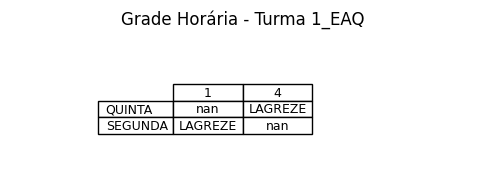

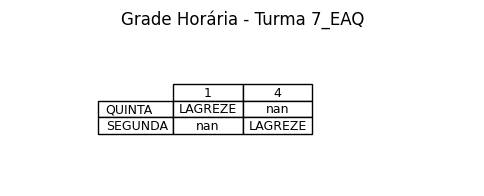

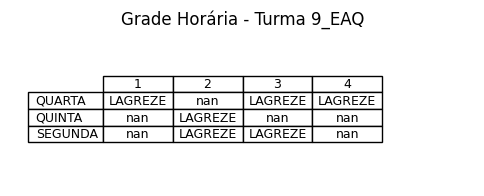

In [42]:
# Função para criar a grade horária visualizada por turma
def plotar_grade_horaria(df):
    # Obter todas as turmas únicas
    turmas = df['Turma'].unique()
    
    for turma in turmas:
        # Filtrar o DataFrame para a turma atual
        df_turma = df[df['Turma'] == turma]

        # Criar um pivot table para visualização
        grade_horaria = df_turma.pivot(index='Dia', columns='Periodo', values='Professor')

        # Plotar a grade horária manualmente
        fig, ax = plt.subplots(figsize=(6, 2))
        ax.axis('off')
        table = ax.table(cellText=grade_horaria.values,
                         rowLabels=grade_horaria.index,
                         colLabels=grade_horaria.columns,
                         cellLoc='center',
                         loc='center')
        table.auto_set_font_size(False)
        table.set_fontsize(9)
        table.auto_set_column_width(col=list(range(len(grade_horaria.columns))))
        plt.title(f'Grade Horária - Turma {turma}')
        plt.show()

# Chamar a função para plotar a grade horária
plotar_grade_horaria(df_resultado)


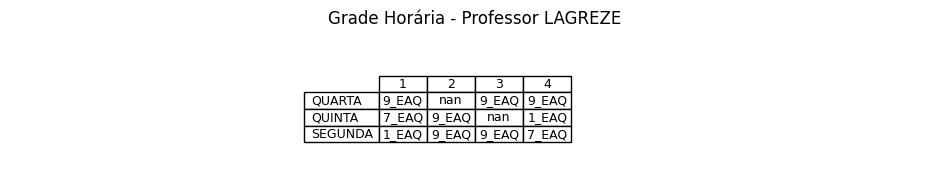

In [27]:

# Função para criar a grade horária visualizada por professor
def plotar_grade_horaria_por_professor(df):
    # Obter todos os professores únicos
    professores = df['Professor'].unique()
    
    for professor in professores:
        # Filtrar o DataFrame para o professor atual
        df_professor = df[df['Professor'] == professor]

        # Criar um pivot table para visualização
        grade_horaria = df_professor.pivot(index='Dia', columns='Periodo', values='Turma')

        # Plotar a grade horária manualmente
        fig, ax = plt.subplots(figsize=(12, 2))
        ax.axis('off')
        table = ax.table(cellText=grade_horaria.values,
                         rowLabels=grade_horaria.index,
                         colLabels=grade_horaria.columns,
                         cellLoc='center',
                         loc='center')
        table.auto_set_font_size(False)
        table.set_fontsize(9)
        table.auto_set_column_width(col=list(range(len(grade_horaria.columns))))
        plt.title(f'Grade Horária - Professor {professor}')
        plt.show()

# Chamar a função para plotar a grade horária
plotar_grade_horaria_por_professor(df_resultado)
